# Overview

- EDA
- sample/feature selection
- baseline model
- validation
- submit

【基本の考え方】  
- Private LB がテストデータで評価されるため、テストデータに基づいてクリーニング、特徴量選択、訓練データの選択、を行う。

In [1]:
# Directories
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/jigsaw-toxic-severity-rating/sample_submission.csv
/kaggle/input/jigsaw-toxic-severity-rating/validation_data.csv
/kaggle/input/jigsaw-toxic-severity-rating/comments_to_score.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test_labels.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.c

In [2]:
# Parameters
DEBUG_FLAG = False
VERSION = 'nb06'

SUBMISSION_PATH = '/kaggle/input/jigsaw-toxic-severity-rating/sample_submission.csv'
VALIDATION_DATA_PATH = '/kaggle/input/jigsaw-toxic-severity-rating/validation_data.csv'
COMMENTS_SCORE_PATH = '/kaggle/input/jigsaw-toxic-severity-rating/comments_to_score.csv'
TOXIC3_TRAIN_PATH = '/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv'

N_SPLITS = 5 if not DEBUG_FLAG else 2

In [3]:
# Modules
import re
import sys
import time

import datatable as dt
import nltk
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib_venn import venn3
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, SGDClassifier, SGDRegressor
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold

sys.setrecursionlimit(5000)

In [4]:
# My functions
def read_df():
    valid = dt.fread(VALIDATION_DATA_PATH).to_pandas()
    test = dt.fread(COMMENTS_SCORE_PATH).to_pandas()
    submission = dt.fread(SUBMISSION_PATH).to_pandas()
    toxic3 = dt.fread(TOXIC3_TRAIN_PATH).to_pandas()
    
    if DEBUG_FLAG:
        valid = valid.sample(n=1000).reset_index(drop=True)
        test = test.sample(n=1000).reset_index(drop=True)
        toxic3 = toxic3.sample(n=1000).reset_index(drop=True)
    
    return valid, test, submission, toxic3

In [5]:
valid, test, submission, toxic3 = read_df()

print(f'valid shape: {valid.shape}')
print(f'test shape: {test.shape}')
print(f'submission shape: {submission.shape}')
print(f'toxic3 shape: {toxic3.shape}')

valid shape: (30108, 3)
test shape: (7537, 2)
submission shape: (7537, 2)
toxic3 shape: (223549, 8)


In [6]:
display(valid.head())
display(test.head())
display(submission.head())
display(toxic3.head())

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"


,comment_id,text
0,114890,"""\n \n\nGjalexei, you asked about whether ther..."
1,732895,"Looks like be have an abuser , can you please ..."
2,1139051,I confess to having complete (and apparently b...
3,1434512,"""\n\nFreud's ideas are certainly much discusse..."
4,2084821,It is not just you. This is a laundry list of ...


,comment_id,score
0,114890,0.5
1,732895,0.5
2,1139051,0.5
3,1434512,0.5
4,2084821,0.5


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,False,False,False,False,False,False
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,False,False,False,False,False,False
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",False,False,False,False,False,False
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",False,False,False,False,False,False
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",False,False,False,False,False,False


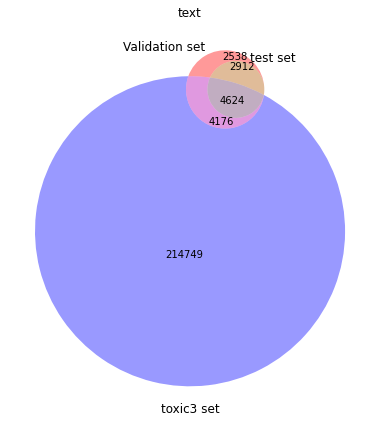

In [7]:
valid_unique_text = set(pd.concat([valid['less_toxic'], valid['more_toxic']]).unique())
test_unique_text = set(test['text'].unique())
toxic3_unique_text = set(toxic3['comment_text'].unique())

plt.figure(figsize=(6,6))
venn3(subsets=(valid_unique_text, test_unique_text, toxic3_unique_text),
      set_labels=('Validation set', 'test set', 'toxic3 set'))
plt.title('text')
plt.tight_layout()
plt.show()

test は validation に含まれている。一方で test は toxic3 に完全に含まれているわけではない。これにより、toxic3 を訓練データとして使う場合、同じテキストのサンプルを選択するよりも、予め特徴抽出した上で、似ているサンプルを選択するのがよいのかもしれない。

方針としては、特徴抽出して、adversarial validation により似ているサンプルセットを使って学習、予測という流れ。

In [8]:
# クリーニング関数
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None, whitelist=None):
    # clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    
    # remove numbers
    text = re.sub(r'[\d]', '', text)
            
    # Tokenize (convert from string to list)
    lst_text = text.split()
    
    # remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
                
    # Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    # Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
    
    # white words list
    if whitelist is not None:
        lst_text = [word for word in lst_text if word in whitelist]
        
    # back to string from list
    text = ' '.join(lst_text)
    
    return text

In [9]:
%%time
stop_words = list(text.ENGLISH_STOP_WORDS)

# test のクリーニング
test['text_clean'] = test['text'].apply(lambda x: 
    utils_preprocess_text(x, flg_stemm=True, flg_lemm=True, lst_stopwords=stop_words, whitelist=None)
)

test_words = set(' '.join(test['text_clean']).split())
print(f'test_words size: {len(test_words)}')

test_words size: 23636
CPU times: user 9.32 s, sys: 136 ms, total: 9.46 s
Wall time: 9.47 s


In [10]:
%%time

# valid のクリーニング
valid_unique_text = pd.Series(pd.concat([valid['less_toxic'], valid['more_toxic']]).unique())
valid_unique_text_cleaned = valid_unique_text.apply(lambda x: 
    utils_preprocess_text(x, flg_stemm=True, flg_lemm=True, lst_stopwords=stop_words, whitelist=test_words)
)
valid_unique_text_dic = {text: cleaned_text for text, cleaned_text in zip(valid_unique_text, valid_unique_text_cleaned)}
valid['less_toxic_clean'] = valid['less_toxic'].map(valid_unique_text_dic)
valid['more_toxic_clean'] = valid['more_toxic'].map(valid_unique_text_dic)

# toxic3 のクリーニング
toxic3 = toxic3.rename(columns={'comment_text': 'text'})
toxic3['text_clean'] = toxic3['text'].apply(lambda x: 
    utils_preprocess_text(x, flg_stemm=True, flg_lemm=True, lst_stopwords=stop_words, whitelist=test_words)
)

CPU times: user 3min 46s, sys: 447 ms, total: 3min 47s
Wall time: 3min 47s


In [11]:
display(valid[['less_toxic', 'less_toxic_clean']])
display(valid[['more_toxic', 'more_toxic_clean']])
display(test[['text', 'text_clean']])
display(toxic3[['text', 'text_clean']])

,less_toxic,less_toxic_clean
0,This article sucks \n\nwoo woo wooooooo,articl suck woo woo wooooooo
1,"""And yes, people should recognize that but the...",ye peopl recogn usual dont object hear direct ...
2,"Western Media?\n\nYup, because every crime in...",western medium yup crime entir world caus west...
3,And you removed it! You numbskull! I don't car...,remov numbskul dont care say anymor life ahead...
4,smelly vagina \n\nBluerasberry why don't you ...,smelli vagina bluerasberri dont model cheesi b...
...,...,...
30103,I'm sorry. I'm not an admin. I will give you t...,im sorri im admin piec advic edit page away gu...
30104,I'm sorry. I'm not an admin. I will give you t...,im sorri im admin piec advic edit page away gu...
30105,"wow...\nare you out of your mind, how was my e...",wow mind edit talk page vandal simpli explain ...
30106,"wow...\nare you out of your mind, how was my e...",wow mind edit talk page vandal simpli explain ...


,more_toxic,more_toxic_clean
0,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...,wher sexi pic gone main page
1,Daphne Guinness \n\nTop of the mornin' my fav...,daphn guin mornin favourit alien life form im ...
2,"""Atom you don't believe actual photos of mastu...",atom dont believ actual photo masturb sexual e...
3,You seem to have sand in your vagina.\n\nMight...,sand vagina want wash stink hole bitch
4,"hey \n\nway to support nazis, you racist",hey way support nazi racist
...,...,...
30103,get out my large penis,larg peni
30104,get out my large penis,larg peni
30105,Piss off you slant eyed-gook,piss slant eyedgook
30106,Piss off you slant eyed-gook,piss slant eyedgook


,text,text_clean
0,"""\n \n\nGjalexei, you asked about whether ther...",gjalexei ask antieditori polici call wikipedia...
1,"Looks like be have an abuser , can you please ...",look like abus look thank
2,I confess to having complete (and apparently b...,confess have complet appar bliss ignor jordan ...
3,"""\n\nFreud's ideas are certainly much discusse...",freud idea certainli discus today agre grappl ...
4,It is not just you. This is a laundry list of ...,just laundri list stupid alleg scoop godknowsw...
...,...,...
7532,"Go away, you annoying vandal.",away annoy vandal
7533,This user is a vandal.,user vandal
7534,""" \n\nSorry to sound like a pain, but one by f...",sorri sound like pain follow tad stalk honesti...
7535,Well it's pretty fucking irrelevant now I'm un...,pretti fuck irrelev im unblock aint


,text,text_clean
0,Explanation\nWhy the edits made under my usern...,explan edit usernam hardcor fan revert werent ...
1,D'aww! He matches this background colour I'm s...,match background colour im seemingli stuck tha...
2,"Hey man, I'm really not trying to edit war. It...",hey man im realli tri edit war just guy consta...
3,"""\nMore\nI can't make any real suggestions on ...",make real suggest improv wonder section statis...
4,"You, sir, are my hero. Any chance you remember...",sir hero chanc rememb page that
...,...,...
223544,":Jerome, I see you never got around to this…! ...",jerom got im surpris look exampl nomin onlin m...
223545,==Lucky bastard== \n http://wikimediafoundatio...,lucki bastard heh famou envi congrat
223546,==shame on you all!!!== \n\n You want to speak...,shame want speak gay romanian
223547,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,mel gibson nazi bitch make shitti movi asshol ...


In [12]:
# クリーニングにより空文字列になった文字列を抽出
print(sum(test['text_clean'].apply(lambda x: len(x)) == 0), '/', len(test))
print(sum(valid['less_toxic_clean'].apply(lambda x: len(x)) == 0), '/', len(valid))
print(sum(valid['more_toxic_clean'].apply(lambda x: len(x)) == 0), '/', len(valid))
print(sum(toxic3['text_clean'].apply(lambda x: len(x)) == 0), '/', len(toxic3))

1 / 7537
21 / 30108
21 / 30108
1461 / 223549


In [13]:
# 空文字列の行を除く
toxic3['word_size'] = toxic3['text_clean'].apply(lambda x: len(x))
valid['less_toxic_size'] = valid['less_toxic_clean'].apply(lambda x: len(x))
valid['more_toxic_size'] = valid['more_toxic_clean'].apply(lambda x: len(x))

toxic3 = toxic3.query('word_size != 0')
valid = valid.query('less_toxic_size != 0 | more_toxic_size != 0')

In [14]:
# preparing adversarial validation
advval_train_X = pd.concat([toxic3['text_clean'], test['text_clean']])
advval_train_y = pd.concat([pd.Series(np.ones(toxic3.shape[0])), pd.Series(np.zeros(test.shape[0]))])
advval_valid_less_X = valid['less_toxic_clean']
advval_valid_more_X = valid['more_toxic_clean']

print(f'advval_train_X shape: {advval_train_X.shape}')
print(f'advval_train_y shape: {advval_train_y.shape}')

advval_train_X shape: (229625,)
advval_train_y shape: (229625,)


In [15]:
%%time

# 特徴抽出
print(f'feature extracting ...')
advval_tfidf = TfidfVectorizer(
    stop_words=stop_words,
    min_df=3,
    max_df=0.5, 
    max_features=100_000,
    analyzer='word',
    ngram_range=(1, 1)
)
advval_train_X_tfidf = advval_tfidf.fit_transform(advval_train_X)
advval_train_X_tfidf_feature_names = advval_tfidf.get_feature_names()
advval_train_X_tfidf_vocab = advval_tfidf.vocabulary_
advval_valid_less_X_tfidf = advval_tfidf.transform(advval_valid_less_X)
advval_valid_more_X_tfidf = advval_tfidf.transform(advval_valid_more_X)

print('Total number of features:', advval_train_X_tfidf.shape[1])

feature extracting ...
Total number of features: 18607
CPU times: user 7.81 s, sys: 116 ms, total: 7.93 s
Wall time: 7.95 s


In [16]:
# idf ranking
idf = {'word': advval_tfidf.get_feature_names(), 'weight': advval_tfidf.idf_}
pd.DataFrame(idf).sort_values('weight', ascending=False).head(10)

,word,weight
18606,ｗｗｗａｎｏｎｔａｌｋｃｏｍ,11.957913
17629,warmak,11.957913
2250,burywiganrochdal,11.957913
2254,bushido,11.957913
14616,sicker,11.957913
17624,warjet,11.957913
14617,sickmind,11.957913
14621,sidd,11.957913
7959,indofijian,11.957913
2267,butro,11.957913


In [17]:
# adversarial validation
def adversarial_validation(train_X, train_y, tfidf):

    models = []
    oof_train = np.zeros((train_X.shape[0],))
    scores = []

    stkf = StratifiedKFold(
        n_splits=N_SPLITS, 
        shuffle=True,
        random_state=None
    )

    # 交差検証
    for fold_id, (train_idx, valid_idx) in enumerate(stkf.split(train_X, train_y)):
        start = time.time()
        print(f'* ' * 40)
        print(f'fold_id: {fold_id}')

        # 訓練データ、評価データ、テストデータを整形
        print(f'preprocessing ...')
        X_trn = train_X.iloc[train_idx].reset_index(drop=True)
        X_val = train_X.iloc[valid_idx].reset_index(drop=True)
        y_trn = train_y.iloc[train_idx].reset_index(drop=True)
        y_val = train_y.iloc[valid_idx].reset_index(drop=True)

        X_trn_tfidf = tfidf.transform(X_trn)
        X_val_tfidf = tfidf.transform(X_val)

        print('Total number of train samples:', X_trn_tfidf.shape[0])
        print('Total number of valid samples:', X_val_tfidf.shape[0])

        # 訓練
        print(f'training ...')
        clf = SGDClassifier(
            loss='log', 
            class_weight='balanced',
            max_iter=10000, 
            tol=1e-3, 
            n_jobs=-1
        )

        clf.fit(X_trn_tfidf, y_trn)

        # 推論
        print(f'predicting ...')
        val_pred = clf.predict_proba(X_val_tfidf)[:, 1]
        oof_train[valid_idx] = val_pred
        models.append(clf)

        # 評価
        print(f'validation ...')
        score_auc = roc_auc_score(y_val, val_pred)
        scores.append(score_auc)
        elapsed = time.time() - start
        print(f'fold {fold_id} - score: {score_auc:.6f}, elapsed time: {elapsed:.2f} [sec]')

    print(f'* ' * 40)
    print(f'Average AUC: {sum(scores)/N_SPLITS:.6f}')
    
    return oof_train, models

In [18]:
%%time
advval_oof_train, advval_models = adversarial_validation(advval_train_X, advval_train_y, advval_tfidf)

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 0
preprocessing ...
Total number of train samples: 183700
Total number of valid samples: 45925
training ...
predicting ...
validation ...
fold 0 - score: 0.799609, elapsed time: 7.49 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 1
preprocessing ...
Total number of train samples: 183700
Total number of valid samples: 45925
training ...
predicting ...
validation ...
fold 1 - score: 0.804230, elapsed time: 7.68 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 2
preprocessing ...
Total number of train samples: 183700
Total number of valid samples: 45925
training ...
predicting ...
validation ...
fold 2 - score: 0.794327, elapsed time: 7.83 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 3
preprocessing ...
Total number of train samples: 183700
Total number of

Average AUC が 0.80 程度だと train と test を分離できそうな分類器ができたということ。すなわち、訓練データとテストデータの特徴量分布が異なることを意味している。いま、訓練データをラベル1、テストデータをラベル0としたので、スコアの低い訓練データを取り出すことで、テストデータに近い訓練データが手に入る。

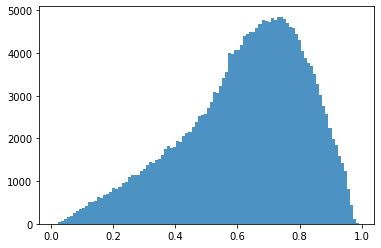

In [19]:
# スコア分布
plt.figure()
plt.hist(advval_oof_train, alpha=.8, bins=100)
plt.show()

In [20]:
advval_oof_train = pd.DataFrame({'oof_train': advval_oof_train, 'y': advval_train_y})
advval_oof_train

,oof_train,y
0,0.612866,1.0
1,0.850895,1.0
2,0.517484,1.0
3,0.892088,1.0
4,0.658010,1.0
...,...,...
7532,0.196153,0.0
7533,0.151820,0.0
7534,0.474894,0.0
7535,0.318727,0.0


In [21]:
# 訓練データのうちテストデータに近いサンプルを抽出
advval_oof_train.query('oof_train < 0.5 & y == 1')

,oof_train,y
6,0.319524,1.0
7,0.253058,1.0
12,0.482344,1.0
16,0.390102,1.0
27,0.446858,1.0
...,...,...
222074,0.468019,1.0
222081,0.388896,1.0
222082,0.429802,1.0
222085,0.314303,1.0


問い。テストデータにない単語を使って学習することに価値はあるか？  
答え。単語の意味の近さを利用せずに分類器を作成する場合にはないと言える。単語がテストデータのテキストが leak しているが、それを逆用する。一方で、深層学習のような枠組みを用いる場合においては、そうとは限らず、という感じ。

In [22]:
advval_train_idx = advval_oof_train.query('oof_train < 0.5 & y == 1').index
print(len(advval_train_idx))

51820


In [23]:
# preparing main training data
main_train_X = toxic3.iloc[advval_train_idx]['text_clean']
main_train_y = toxic3.iloc[advval_train_idx][['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)
main_train_y += toxic3.iloc[advval_train_idx]['severe_toxic']
main_train_y /= main_train_y.max()
main_valid_less_X = valid['less_toxic_clean']
main_valid_more_X = valid['more_toxic_clean']

print(f'main_train_X shape: {advval_train_X.shape}')
print(f'main_train_y shape: {advval_train_y.shape}')
print(f'main_valid_less_X shape: {main_valid_less_X.shape}')
print(f'main_valid_more_X shape: {main_valid_more_X.shape}')

main_train_X shape: (229625,)
main_train_y shape: (229625,)
main_valid_less_X shape: (30108,)
main_valid_more_X shape: (30108,)


In [24]:
# 特徴抽出
print(f'feature extracting ...')
main_tfidf = TfidfVectorizer(
    stop_words=stop_words,
    min_df=3,
    max_df=0.5, 
    max_features=100_000,
    analyzer='word',
    ngram_range=(1, 1)
)

main_train_X_tfidf = main_tfidf.fit_transform(main_train_X)
main_train_X_tfidf_feature_names = main_tfidf.get_feature_names()
main_train_X_tfidf_vocab = main_tfidf.vocabulary_
main_valid_less_X_tfidf = main_tfidf.transform(main_valid_less_X)
main_valid_more_X_tfidf = main_tfidf.transform(main_valid_more_X)

print('Total number of features:', main_train_X_tfidf.shape[1])

feature extracting ...
Total number of features: 12522


In [25]:
# idf ranking
idf = {'word': main_tfidf.get_feature_names(), 'weight': main_tfidf.idf_}
pd.DataFrame(idf).sort_values('weight', ascending=False).head(10)

,word,weight
1519,bummer,10.469256
10347,stalkerish,10.469256
1671,carnildo,10.469256
10358,starbuck,10.469256
10363,startl,10.469256
1666,carioca,10.469256
10368,statesman,10.469256
6734,mcmahon,10.469256
1661,carelessli,10.469256
6726,mbk,10.469256


In [26]:
# main
def main_training(train_X, train_y, tfidf):

    models = []
    oof_train = np.zeros((train_X.shape[0],))
    scores = []

    kf = KFold(
        n_splits=N_SPLITS, 
        shuffle=True,
        random_state=None
    )

    # 交差検証
    for fold_id, (train_idx, valid_idx) in enumerate(kf.split(train_X, train_y)):
        start = time.time()
        print(f'* ' * 40)
        print(f'fold_id: {fold_id}')

        # 訓練データ、評価データ、テストデータを整形
        print(f'preprocessing ...')
        X_trn = train_X.iloc[train_idx].reset_index(drop=True)
        X_val = train_X.iloc[valid_idx].reset_index(drop=True)
        y_trn = train_y.iloc[train_idx].reset_index(drop=True)
        y_val = train_y.iloc[valid_idx].reset_index(drop=True)

        X_trn_tfidf = tfidf.transform(X_trn)
        X_val_tfidf = tfidf.transform(X_val)

        print('Total number of train samples:', X_trn_tfidf.shape[0])
        print('Total number of valid samples:', X_val_tfidf.shape[0])

        # 訓練
        print(f'training ...')
        reg = Ridge(
            max_iter=10000, 
            tol=1e-3
        )

        reg.fit(X_trn_tfidf, y_trn)

        # 推論
        print(f'predicting ...')
        val_pred = reg.predict(X_val_tfidf)
        oof_train[valid_idx] = val_pred
        models.append(reg)

        # 評価
        print(f'validation ...')
        score_mse = mean_squared_error(y_val, val_pred)
        scores.append(score_mse)
        elapsed = time.time() - start
        print(f'fold {fold_id} - score: {score_mse:.6f}, elapsed time: {elapsed:.2f} [sec]')

    print(f'* ' * 40)
    print(f'Average MSE: {sum(scores)/N_SPLITS:.6f} Average RMSE: {np.sqrt(sum(scores)/N_SPLITS):.6f}')
    
    return oof_train, models

In [27]:
%%time
main_oof_train, main_models = main_training(main_train_X, main_train_y, main_tfidf)

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 0
preprocessing ...
Total number of train samples: 41456
Total number of valid samples: 10364
training ...
predicting ...
validation ...
fold 0 - score: 0.016139, elapsed time: 1.56 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 1
preprocessing ...
Total number of train samples: 41456
Total number of valid samples: 10364
training ...
predicting ...
validation ...
fold 1 - score: 0.016795, elapsed time: 1.60 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 2
preprocessing ...
Total number of train samples: 41456
Total number of valid samples: 10364
training ...
predicting ...
validation ...
fold 2 - score: 0.016975, elapsed time: 1.61 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 3
preprocessing ...
Total number of train samples: 41456
Total number of val

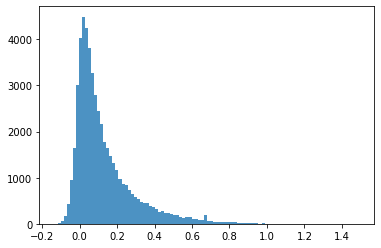

In [28]:
# スコア分布
plt.figure()
plt.hist(main_oof_train, alpha=.8, bins=100)
plt.show()

In [29]:
# adversarial validation によりテストデータに近い評価データを作成
advval_score_valid_less_toxic = np.array([clf.predict_proba(advval_valid_less_X_tfidf)[:, 1] for clf in advval_models]).sum(axis=0) / len(advval_models)
advval_score_valid_more_toxic = np.array([clf.predict_proba(advval_valid_more_X_tfidf)[:, 1] for clf in advval_models]).sum(axis=0) / len(advval_models)

test_like_valid_idx = (advval_score_valid_less_toxic < 0.5) & (advval_score_valid_more_toxic < 0.5)
print(sum(test_like_valid_idx), '/', len(test_like_valid_idx))

17242 / 30108


In [30]:
# validation score
preds_less_toxic = np.array([reg.predict(main_valid_less_X_tfidf[test_like_valid_idx]) for reg in main_models]).sum(axis=0)
preds_more_toxic = np.array([reg.predict(main_valid_more_X_tfidf[test_like_valid_idx]) for reg in main_models]).sum(axis=0)

print((preds_less_toxic < preds_more_toxic).mean())

0.6975988864400882


In [31]:
test_X_tfidf = main_tfidf.transform(test['text_clean'])
preds_test = np.array([reg.predict(test_X_tfidf) for reg in main_models]).sum(axis=0)
submission['score'] = preds_test

pd.DataFrame(pd.Series(submission['score'].ravel()).describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
0,7537.0,0.662841,0.832572,-0.722576,0.107814,0.371069,0.948688,5.232735


In [32]:
submission.to_csv('submission.csv', index=False)